In [ ]:
!pip install catboost open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/res.zip

Archive:  drive/MyDrive/res.zip
   creating: res/
   creating: res/safety-doors/
res/safety-doors/08_00 МСК 23 мая-20240305T095937Z-001/:  mismatching "local" filename (res/safety-doors/08_00 ╨Ь╨б╨Ъ 23 ╨╝╨░╤П-20240305T095937Z-001/),
         continuing with "central" filename version
   creating: res/safety-doors/08_00 МСК 23 мая-20240305T095937Z-001/
res/safety-doors/08_00 МСК 23 мая-20240305T095937Z-001/08_00 МСК 23 мая/:  mismatching "local" filename (res/safety-doors/08_00 ╨Ь╨б╨Ъ 23 ╨╝╨░╤П-20240305T095937Z-001/08_00 ╨Ь╨б╨Ъ 23 ╨╝╨░╤П/),
         continuing with "central" filename version
   creating: res/safety-doors/08_00 МСК 23 мая-20240305T095937Z-001/08_00 МСК 23 мая/
res/safety-doors/08_00 МСК 23 мая-20240305T095937Z-001/08_00 МСК 23 мая/point _end/:  mismatching "local" filename (res/safety-doors/08_00 ╨Ь╨б╨Ъ 23 ╨╝╨░╤П-20240305T095937Z-001/08_00 ╨Ь╨б╨Ъ 23 ╨╝╨░╤П/point _end/),
         continuing with "central" filename version
   creating: res/safety-doors/08_00 МСК 23 мая-202

In [ ]:
import pandas as pd
import numpy as np
import scipy

import json

import open3d as o3d

from tqdm import tqdm
import os

from typing import List, Dict,Tuple,Any

from lightgbm import LGBMClassifier

import catboost
from catboost import CatBoostClassifier, Pool

import sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split,KFold,GroupKFold,StratifiedGroupKFold,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
object_classes = {
    'limb': 0,
    'other': 1,
    'wear': 2,
    'human': 3
}
object_classes_color_map = {
    0: (0, 1, 0),
    1: (0.2, 0.2, 0.2),
    2: (1, 0, 0),
    3: (0, 0, 1)
}

In [ ]:
import math

class PointCloudDataset(object):
    def __init__(self, points_path: str, ann_path: str, knn: int, radius: float, min_neighbours):
        """
            In :
              data_path: str - путь до папки с данными
              grouping_method : str - метод поиска соседей , ["knn","radius_search",имплементированный вами]
              neighbourhood_th : Any[int,float] - пороговое значение для k - количества соседей или radius - радиуса сферы
        """

        self.points_path = points_path
        self.ann_path = ann_path
        self.knn = knn
        self.radius = radius
        self.min_neighbours = min_neighbours

        self.feature_names = ['x', 'y', 'z', 'intensity', 'eigenvals_sum', 'linearity', 'planarity', 'change_of_curvature',
                            'scattering', 'omnivariance', 'anisotropy', 'eigenentropy', 'label','scene_id']

    def create_cuboid(cub):
        position = cub['geometry']['position']
        rotation = cub['geometry']['rotation']
        dimensions = cub['geometry']['dimensions']
        # Создание кубоида
        extent = np.array([dimensions['x'], dimensions['y'], dimensions['z']])
        center = np.array([position['x'], position['y'], position['z']])
        euler = np.array([rotation['x'], rotation['y'], rotation['z']])

        Rx = np.array([
            [1, 0, 0],
            [0, np.cos(euler[0]), -np.sin(euler[0])],
            [0, np.sin(euler[0]), np.cos(euler[0])]
        ])
        Ry = np.array([
            [np.cos(euler[1]), 0, np.sin(euler[1])],
            [0, 1, 0],
            [-np.sin(euler[1]), 0, np.cos(euler[1])]
        ])
        Rz = np.array([
            [np.cos(euler[2]), -np.sin(euler[2]), 0],
            [np.sin(euler[2]), np.cos(euler[2]), 0],
            [0, 0, 1]
        ])
        rot = np.linalg.inv(Rx @ Ry @ Rz)

        return center, extent / 2, rot, cub['objectKey']

    def read_scene_from_file(self, points_file, ann_file) -> Tuple[np.ndarray,np.ndarray]:
        cloud = o3d.io.read_point_cloud(points_file)
        cloud = cloud.voxel_down_sample(voxel_size=0.025)
        cloud, _ = cloud.remove_statistical_outlier(nb_neighbors=20, std_ratio=1.5)
        points = np.array(cloud.points)
        colors = np.array(cloud.colors)[:, 0]

        with open(ann_file) as f:
            json_data = json.load(f)
            cuboids = [PointCloudDataset.create_cuboid(x) for x in json_data['figures']]
            objects = dict((x['key'], x['classTitle']) for x in json_data['objects'])

        labels = []
        for point in points:
            label = object_classes['other']
            for center, hextent, rot, key in cuboids:
                point_local = np.dot(point[:3] - center, rot)
                if np.all(np.abs(point_local) <= hextent):
                    label = object_classes[objects[key]]
                    break
            labels.append(label)
        return points, colors, labels

    def load_from_directory(self) -> Tuple[List[np.ndarray],List[np.ndarray]]:
        for points_file, ann_file in zip(sorted(os.listdir(self.points_path)), sorted(os.listdir(self.ann_path))):
            points_file = os.path.join(self.points_path, points_file)
            ann_file = os.path.join(self.ann_path, ann_file)

            yield self.read_scene_from_file(points_file, ann_file)

    def create_kdtree(self, points: np.ndarray)-> Tuple[o3d.geometry.PointCloud,o3d.geometry.KDTreeFlann]:
        xyz = o3d.utility.Vector3dVector(points)
        pcd = o3d.geometry.PointCloud()
        pcd.points = xyz

        tree = o3d.geometry.KDTreeFlann(pcd)

        return pcd, tree

    def rknn_search(self, pcd: o3d.geometry.PointCloud, tree: o3d.geometry.KDTreeFlann, query_index: int, k: int, radius: float) -> np.ndarray:
        _, indices, _ = tree.search_hybrid_vector_3d(pcd.points[query_index], radius, k)

        return np.array(pcd.points)[indices]

    def get_eugen_stats(self, neighbourhood_points: np.ndarray) -> Tuple[float, ...]:
        """
        In :
            neighbourhood_points: np.ndarray  Облако соседних точек найденных с помощью knn или radius_search
        Out :
            feautes: Tuple[float, ...]  -> признаки вычисленные по данному облаку точек
        """

        centered = neighbourhood_points - np.mean(neighbourhood_points, axis=0)[None, :]
        cov = np.cov(centered.T)
        assert cov.shape == (3, 3)
        e, v = np.linalg.eig(cov)
        e = np.real(e)[::-1]
        s = np.sum(e)

        e = np.clip(e, 0, None) + 1e-6

        sum_of_eigenvalues = s
        linearity = (e[0] - e[1]) / e[2]
        planarity = (e[1] - e[2]) / e[0]
        scattering = e[2] / e[0]
        omnivariance = 3 * math.sqrt(e[0] * e[1] * e[2])
        anisotropy = (e[0] - e[2]) / e[0]
        eigentropy = -(e[0] / s + math.log(e[0] / s)) - (e[1] / s + math.log(e[1] / s)) - (e[2] / s + math.log(e[2] / s))
        change_of_curvature = (e[0] - e[1]) / s

        return sum_of_eigenvalues, linearity, planarity, change_of_curvature, scattering, omnivariance, anisotropy, eigentropy

    def create_dataset(self) -> pd.DataFrame:
        data = []
        for scene_id, (points, colors, labels) in tqdm(enumerate(self.load_from_directory()), desc='Scene processing'):
            pcd, tree = self.create_kdtree(points)

            for i, (point, color, label) in enumerate(zip(points, colors, labels)):
                neighbors = self.rknn_search(pcd, tree, i, self.knn, self.radius)

                if len(neighbors) < self.min_neighbours or point[2] < 3:
                  continue

                features = self.get_eugen_stats(neighbors)

                point_data = list(point) + [color] + list(features) + [label, scene_id+1]
                data.append(point_data)

        dataframe = pd.DataFrame(data, columns=self.feature_names)
        return dataframe

In [ ]:
knn = 40
radius = 0.15

In [ ]:
train_data_path = 'res/safety-doors/08_00 МСК 23 мая-20240305T095937Z-001/08_00 МСК 23 мая/point _end/point _end'
points_path = os.path.join(train_data_path, 'clouds_tof')
ann_path = os.path.join(train_data_path, 'clouds_tof_ann')

train_dataset = PointCloudDataset(points_path, ann_path, knn, radius, knn//4)
train_dataframe = train_dataset.create_dataset()
train_dataframe

Scene processing: 100it [05:39,  3.39s/it]


,x,y,z,intensity,eigenvals_sum,linearity,planarity,change_of_curvature,scattering,omnivariance,anisotropy,eigenentropy,label,scene_id
0,0.909000,0.71400,4.752750,0.000000,0.004470,0.078096,-7.486339,0.066454,7.871598,0.000055,-6.871598,4.563989,1,1
1,0.834000,0.71400,4.746500,0.000000,0.005100,0.075197,-6.577140,0.062254,7.047213,0.000080,-6.047213,4.226176,1,1
2,0.823000,0.71400,4.845834,0.000000,0.004942,-0.314447,-11.152906,-0.220447,17.727147,0.000089,-16.727147,3.931894,1,1
3,0.814200,0.71400,4.864950,0.000000,0.004147,-0.386476,-7.183049,-0.251724,13.337770,0.000078,-12.337770,3.649463,1,1
4,0.802500,0.71400,4.856625,0.000000,0.004737,-0.365717,-9.635067,-0.246430,16.767066,0.000086,-15.767066,3.857950,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103327,0.678000,0.12300,5.173250,0.000000,0.002911,0.087755,-2.783025,0.059063,3.477828,0.000062,-2.477828,3.043742,3,100
1103328,-0.783875,-0.49300,5.566490,0.019608,0.001679,0.303143,-1.307177,0.166266,1.770472,0.000032,-0.770472,2.711948,1,100
1103329,0.690000,0.12600,5.120084,0.000000,0.003143,0.094918,-3.554128,0.068552,4.159332,0.000061,-3.159332,3.328192,3,100
1103330,0.295650,-0.49005,3.370213,0.326471,0.002408,3.315797,0.605906,0.169500,0.091314,0.000037,0.908686,3.493311,3,100


In [ ]:
train_dataframe.to_csv(f'drive/MyDrive/test_{knn}_{radius}.csv')

In [ ]:
def visualize_point_cloud(points: np.ndarray, labels: np.ndarray, smoothen=False) -> go.Figure:
    if not smoothen:
        colors = [object_classes_color_map[label] for label in labels]
    else:
        xyz = o3d.utility.Vector3dVector(points)
        pcd = o3d.geometry.PointCloud()
        pcd.points = xyz
        tree = o3d.geometry.KDTreeFlann(pcd)

        k = 10
        colors = []
        for i, point in enumerate(points):
            _, indices, _ = tree.search_knn_vector_3d(point, k)
            values, counts = np.unique(labels[np.array(indices)], return_counts=True, axis=0)
            # print(values, counts, len(indices))
            # assert np.all(values[np.argmax(counts)] != np.array([0, 0, 0]))
            label = values[np.argmax(counts)]
            colors.append(object_classes_color_map[label])

    fig = go.Figure(data=[go.Scatter3d(x=points[:,0],y=points[:,1], z=points[:,2],
        mode='markers',
        marker=dict(color=colors, size=5))])

    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        zaxis=dict(range=[-1, 0], autorange='reversed')
    ))
    return fig

In [ ]:
scene_0 = train_dataframe[train_dataframe["scene_id"] == 47]
points  = scene_0.to_numpy()[:,:3]
labels = scene_0.to_numpy()[:,-2]
colors = [object_classes_color_map[label] for label in labels]
visualize_point_cloud(points, colors)

KeyError: (0.2, 0.2, 0.2)

In [ ]:
# weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.arange(4), y=df['label'])
weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.arange(4), y=train_dataframe['label'])
class_weights = dict(zip(object_classes, weights))
class_weights

{'limb': 145.40484976278333,
 'other': 0.29277811920524177,
 'wear': 51.60579981290926,
 'human': 1.791507271038599}

In [ ]:
class_weights={0: 100, 1: 2.5, 2: 50, 3: 1.5}
#class_weights={object_classes[name]: val for name, val in class_weights.items()}
class_weights

{0: 100, 1: 2.5, 2: 50, 3: 1.5}

In [ ]:
drop_cols = ['x']
# drop_cols = ['x', 'y', 'z']

# Catboost

In [ ]:
import sklearn

class Trainer(object):
  def __init__(self,train_data : pd.DataFrame, test_data: pd.DataFrame, model_config: Dict, n_folds: int):
      self.model_params = model_config
      self.n_folds = n_folds
      self.train_data = train_data
      self.test_data = test_data
      self.metrics = ['TotalF1:average=Weighted;use_weights=False', 'Accuracy']
      self.folds = self.create_folds()

  def create_folds(self) -> List[List[np.ndarray]]:
      kfold_dset_index = []
      kf = sklearn.model_selection.KFold(n_splits=n_folds, shuffle=True)
      # kf = sklearn.model_selection.StratifiedKFold(n_splits=n_folds)
      for train_index, val_index in kf.split(self.train_data):
          kfold_dset_index.append([train_index, val_index])

      return kfold_dset_index

  def train_catboost(self, train_pool: catboost.Pool, val_pool: catboost.Pool) -> catboost.CatBoostClassifier:
      catboost_model = catboost.CatBoostClassifier(**self.model_params)
      catboost_model.fit(train_pool, eval_set=val_pool, use_best_model=True)
      # catboost_model.fit(train_pool)

      return catboost_model

  def test_catboost(self, test_pool: catboost.Pool, catboost_model:catboost.CatBoostClassifier) -> List[float]:
      metric_values = catboost_model.eval_metrics(test_pool, metrics=self.metrics)

      return {key: m[-1] for key, m in metric_values.items()}

  def fit(self):
      X = self.train_data.drop(columns=["label","scene_id"]+drop_cols)
      y = self.train_data['label']

      X_test = self.test_data.drop(columns=["label","scene_id"]+drop_cols)
      y_test = self.test_data['label']

      self.f1_list=[]
      self.acc_list=[]
      self.models_list = []

      for fold_id, (train_index, val_index) in enumerate(tqdm(self.folds, desc='KFold')):

          X_val, y_val = X.iloc[val_index], y.iloc[val_index]
          X_train, y_train = X.iloc[train_index], y.iloc[train_index]

          train_pool = catboost.Pool(data=X_train, label=y_train)
          val_pool = catboost.Pool(data=X_val, label=y_val)

          catboost_model = self.train_catboost(train_pool, val_pool)

          test_pool = catboost.Pool(data=X_test, label=y_test)

          metrics = self.test_catboost(test_pool, catboost_model)
          f1 = metrics['TotalF1:average=Weighted;use_weights=false']
          acc = metrics['Accuracy']

          self.f1_list.append(f1)
          self.acc_list.append(acc)
          self.models_list.append(catboost_model)

          del X_train,y_train,X_val,y_val,train_pool,val_pool,test_pool,catboost_model
      print(self.f1_list)
      self.print_stats()

  def print_stats(self):
      # print('f1: ', self.f1_list)
      print('\n================================')
      print(f"F1={np.mean(self.f1_list)} +/- {np.std(self.f1_list)}")
      print(f"Accuracy={np.mean(self.acc_list)} +/- {np.std(self.acc_list)}")


  def return_best(self):
      model_index = self.f1_list.index(max(self.f1_list))
      model = self.models_list[model_index]
      return model

In [ ]:
train_set, test_set = train_test_split(train_dataframe, test_size=0.2)

In [ ]:
params = {
    'task_type': 'GPU',
    'class_weights': class_weights,
    'loss_function': 'MultiClass',
    'depth': 3,
    'iterations': 500,
    'learning_rate': 0.04,
    'logging_level':'Silent'
}
n_folds = 8
trainer = Trainer(train_set, test_set, params, n_folds)
trainer.fit()

KFold: 100%|██████████| 8/8 [01:20<00:00, 10.08s/it]

[0.9211154313209243, 0.9219445377300178, 0.9210232366932974, 0.9217281489933957, 0.9218242792652719, 0.9219750532229782, 0.9216534873267803, 0.9225013058885938]

F1=0.9217206850551574 +/- 0.00044612937811583473
Accuracy=0.8988441835078438 +/- 0.0008433966961360277


In [ ]:
best_model = trainer.return_best()

In [ ]:
best_model.save_model('catboost1')

## Тестируем

In [ ]:
X_test = test_set[test_set['scene_id'] == 43].drop(columns=["label","scene_id"])
y_test = test_set[test_set['scene_id'] == 43]['label']
y_pred = best_model.predict(X_test.drop(drop_cols, axis=1))
# y_pred = best_model.predict(X_test)

In [ ]:
points  = X_test.to_numpy()[:,:3]
labels = y_test.to_numpy()
visualize_point_cloud(points, labels)

In [ ]:
points  = X_test.to_numpy()[:,:3]
labels = y_pred.reshape(-1,)
visualize_point_cloud(points, labels, smoothen=True)

# RandomForest

In [ ]:
class Trainer(object):
    def __init__(self, train_data: pd.DataFrame, test_data: pd.DataFrame, model_config: Dict, n_folds: int):
        self.model_params = model_config
        self.n_folds = n_folds
        self.train_data = train_data
        self.test_data = test_data
        self.metrics = ['f1_weighted', 'accuracy']
        self.folds = self.create_folds()

    def create_folds(self) -> List[List[np.ndarray]]:
        kfold_dset_index = []
        kf = KFold(n_splits=self.n_folds, shuffle=True)
        for train_index, val_index in kf.split(self.train_data):
            kfold_dset_index.append([train_index, val_index])
        return kfold_dset_index

    def train_random_forest(self, X_train: pd.DataFrame, y_train: pd.Series) -> RandomForestClassifier:
        rf_model = RandomForestClassifier(**self.model_params)
        rf_model.fit(X_train, y_train)
        return rf_model

    def test_random_forest(self, X_test: pd.DataFrame, y_test: pd.Series, rf_model: RandomForestClassifier) -> Dict[str, float]:
        y_pred = rf_model.predict(X_test)
        metrics = {
            'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
            'accuracy': accuracy_score(y_test, y_pred)
        }
        return metrics

    def fit(self):
        drop_cols = ["label", "scene_id"]  # or any other columns you want to drop
        X = self.train_data.drop(columns=drop_cols)
        y = self.train_data['label']

        X_test = self.test_data.drop(columns=drop_cols)
        y_test = self.test_data['label']

        self.f1_list = []
        self.acc_list = []
        self.models_list = []

        for fold_id, (train_index, val_index) in enumerate(tqdm(self.folds, desc='KFold')):
            X_val, y_val = X.iloc[val_index], y.iloc[val_index]
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]

            rf_model = self.train_random_forest(X_train, y_train)

            metrics = self.test_random_forest(X_test, y_test, rf_model)
            f1 = metrics['f1_weighted']
            acc = metrics['accuracy']

            self.f1_list.append(f1)
            self.acc_list.append(acc)
            self.models_list.append(rf_model)

            del X_train, y_train, X_val, y_val, rf_model
        print(self.f1_list)
        self.print_stats()

    def print_stats(self):
        print('\n================================')
        print(f"F1={np.mean(self.f1_list)} +/- {np.std(self.f1_list)}")
        print(f"Accuracy={np.mean(self.acc_list)} +/- {np.std(self.acc_list)}")

    def return_best(self):
        model_index = self.f1_list.index(max(self.f1_list))
        model = self.models_list[model_index]
        return model


In [ ]:
train_set, test_set = train_test_split(train_dataframe, test_size=0.2)

In [ ]:
params = {
    'n_estimators': 100,  # Аналог 'iterations' в CatBoost
    'max_depth': 3,  # Аналог 'depth' в CatBoost
    'class_weight': class_weights,  # Аналог 'class_weights' в CatBoost
    'criterion': 'gini',  # Можно выбрать 'gini' или 'entropy'
    'random_state': 42,  # Для воспроизводимости
    'n_jobs': -1  # Использование всех процессоров для ускорения
}

n_folds = 8
trainer = Trainer(train_set, test_set, params, n_folds)
trainer.fit()

KFold: 100%|██████████| 8/8 [10:44<00:00, 80.55s/it]

[0.8248074600381071, 0.8281396953237556, 0.8284818477630848, 0.8269961621726106, 0.8296127089563774, 0.8271065751379922, 0.827160360588173, 0.8263802429571161]

F1=0.8273356316171521 +/- 0.001353156330543753
Accuracy=0.8663342275918012 +/- 0.0006337395013454744


# LightGMB

In [ ]:
class Trainer(object):
    def __init__(self, train_data: pd.DataFrame, test_data: pd.DataFrame, model_config: Dict, n_folds: int):
        self.model_params = model_config
        self.n_folds = n_folds
        self.train_data = train_data
        self.test_data = test_data
        self.metrics = ['f1_weighted', 'accuracy']
        self.folds = self.create_folds()

    def create_folds(self) -> List[List[np.ndarray]]:
        kfold_dset_index = []
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        for train_index, val_index in kf.split(self.train_data):
            kfold_dset_index.append([train_index, val_index])
        return kfold_dset_index

    def train_lightgbm(self, X_train: pd.DataFrame, y_train: pd.Series) -> LGBMClassifier:
        lgb_model = LGBMClassifier(**self.model_params)
        lgb_model.fit(X_train, y_train)
        return lgb_model

    def test_lightgbm(self, X_test: pd.DataFrame, y_test: pd.Series, lgb_model: LGBMClassifier) -> Dict[str, float]:
        y_pred = lgb_model.predict(X_test)
        metrics = {
            'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
            'accuracy': accuracy_score(y_test, y_pred)
        }
        return metrics

    def fit(self):
        drop_cols = ["label", "scene_id"]  # or any other columns you want to drop
        X = self.train_data.drop(columns=drop_cols)
        y = self.train_data['label']

        X_test = self.test_data.drop(columns=drop_cols)
        y_test = self.test_data['label']

        self.f1_list = []
        self.acc_list = []
        self.models_list = []

        for fold_id, (train_index, val_index) in enumerate(tqdm(self.folds, desc='KFold')):
            X_val, y_val = X.iloc[val_index], y.iloc[val_index]
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]

            lgb_model = self.train_lightgbm(X_train, y_train)

            metrics = self.test_lightgbm(X_test, y_test, lgb_model)
            f1 = metrics['f1_weighted']
            acc = metrics['accuracy']

            self.f1_list.append(f1)
            self.acc_list.append(acc)
            self.models_list.append(lgb_model)

            del X_train, y_train, X_val, y_val, lgb_model
        print(self.f1_list)
        self.print_stats()

    def print_stats(self):
        print('\n================================')
        print(f"F1={np.mean(self.f1_list)} +/- {np.std(self.f1_list)}")
        print(f"Accuracy={np.mean(self.acc_list)} +/- {np.std(self.acc_list)}")

    def return_best(self):
        model_index = self.f1_list.index(max(self.f1_list))
        model = self.models_list[model_index]
        return model


In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': len(np.unique(train_set['label'])),  # количество классов
    'class_weight': 'balanced',  # автоматически вычислить веса классов
    'max_depth': 3,  # аналог 'depth' в CatBoost
    'n_estimators': 100,  # аналог 'iterations' в CatBoost
    'learning_rate': 0.04,  # аналог 'learning_rate' в CatBoost
    'verbosity': -1  # аналог 'logging_level':'Silent' в CatBoost
}

n_folds = 8
trainer = Trainer(train_set, test_set, params, n_folds)
trainer.fit()

KFold: 100%|██████████| 8/8 [03:40<00:00, 27.52s/it]

[0.8940274022847735, 0.8948424158718762, 0.8950446380869995, 0.8944505515582118, 0.8942754835561962, 0.8939147442518912, 0.8955112025001639, 0.894183555934554]

F1=0.8945312492555834 +/- 0.0005181047388422203
Accuracy=0.8703549919108884 +/- 0.0007642625094639551


# Интерпретация

Text(0.5, 1.0, 'Feature Importance')

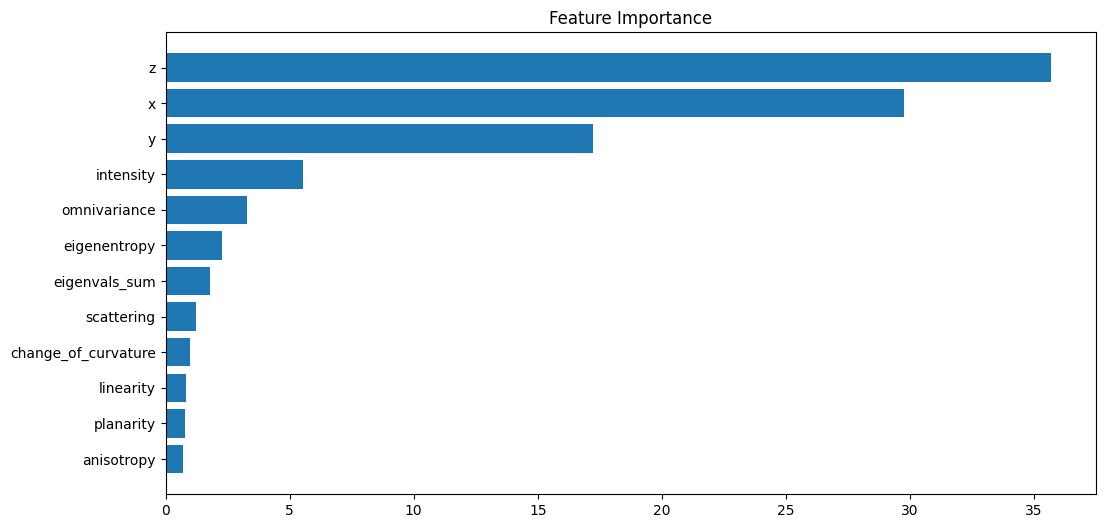

In [ ]:
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
# plt.yticks(range(len(sorted_idx)), np.array(X_test.drop(['x','y','z'],axis=1).columns)[sorted_idx])
plt.title('Feature Importance')